# MNIST NN From Scratch



# Reference : 
- https://youtu.be/6yqMovGDSsE
- https://youtu.be/URJ9pP1aURo
    
URL : https://radiant-jalebi-2bfba6.netlify.app/
        

In [1]:
import numpy as np
import pandas as pd
import json
from matplotlib import pyplot as plt

data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

## 데이터셋 분리

In [2]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_,m_train = X_train.shape

In [3]:
X_train[:,100]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     


**Forward propagation**

- $Z^{[1]} = W^{[1]} X + b^{[1]}$
- $A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$
- $Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$
- $A^{[2]} = g_{\text{softmax}}(Z^{[2]})$

**Backward propagation**

$dZ^{[2]} = A^{[2]} - Y$
$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$
$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$
$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$
$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$
$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$

**Parameter updates**

$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$
$b^{[2]} := b^{[2]} - \alpha db^{[2]}$
$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$
$b^{[1]} := b^{[1]} - \alpha db^{[1]}$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

## 기능 모듈화

In [4]:
def init_params():
    W1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    W2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

## 추론 및 평가

In [5]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [6]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.1, 900)

Iteration:  0
[9 9 6 ... 4 8 4] [1 1 4 ... 4 9 5]
0.09192682926829268
Iteration:  10
[1 1 6 ... 6 7 6] [1 1 4 ... 4 9 5]
0.20097560975609757
Iteration:  20
[7 1 6 ... 6 7 0] [1 1 4 ... 4 9 5]
0.26634146341463416
Iteration:  30
[7 1 6 ... 6 7 0] [1 1 4 ... 4 9 5]
0.3314146341463415
Iteration:  40
[1 1 6 ... 6 7 0] [1 1 4 ... 4 9 5]
0.39707317073170734
Iteration:  50
[1 1 6 ... 6 7 0] [1 1 4 ... 4 9 5]
0.4492926829268293
Iteration:  60
[1 1 6 ... 6 7 0] [1 1 4 ... 4 9 5]
0.4993170731707317
Iteration:  70
[1 1 6 ... 6 7 5] [1 1 4 ... 4 9 5]
0.5408780487804878
Iteration:  80
[1 1 6 ... 6 9 5] [1 1 4 ... 4 9 5]
0.5715365853658536
Iteration:  90
[1 1 4 ... 6 9 5] [1 1 4 ... 4 9 5]
0.5980487804878049
Iteration:  100
[1 1 4 ... 6 9 5] [1 1 4 ... 4 9 5]
0.6198780487804878
Iteration:  110
[1 1 4 ... 4 9 5] [1 1 4 ... 4 9 5]
0.6407560975609756
Iteration:  120
[1 1 4 ... 4 9 5] [1 1 4 ... 4 9 5]
0.6617804878048781
Iteration:  130
[1 1 4 ... 4 9 5] [1 1 4 ... 4 9 5]
0.6848048780487805
Iteration:  1

~85% accuracy on training set.

In [7]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [1]
Label:  1


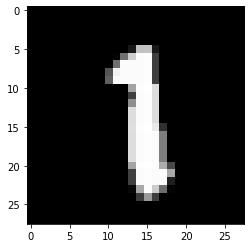

Prediction:  [8]
Label:  8


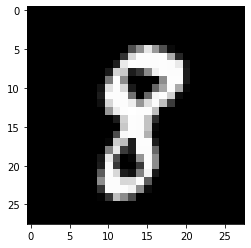

Prediction:  [5]
Label:  5


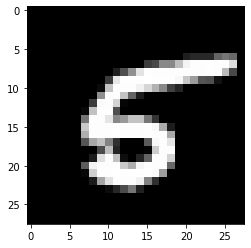

Prediction:  [3]
Label:  3


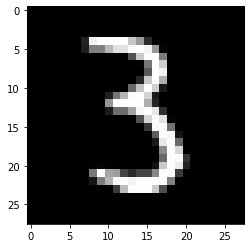

In [8]:
test_prediction(1, W1, b1, W2, b2)
test_prediction(11, W1, b1, W2, b2)
test_prediction(12, W1, b1, W2, b2)
test_prediction(13, W1, b1, W2, b2)

## 파라미터 행렬 계산으로 직접 추론

In [9]:
print(W1.tolist())

[[-0.4602162585889714, 0.07512499153491947, 0.06905438540274544, -0.22991122366064032, -0.20059673064561456, 0.3314870766118517, -0.08971879174721498, -0.22919739897177738, 0.47715070358539835, 0.0031423472262879226, 0.4949393781683613, -0.48629891074027076, 0.035194844206471, 0.3655994032301035, 0.46265426889754097, 0.3127678926041351, 0.27821891170957636, 0.03343683907507988, -0.4720763130005383, -0.03443101884862576, -0.12465001090906602, -0.36545928671483363, -0.425912694578397, -0.47146977123488243, -0.441751494729266, -0.3622254666282667, -0.27122318976460336, 0.05388296572463536, 0.027056518443014932, -0.13039533786808255, -0.48442885057815543, -0.42694654160367973, 0.37349409199286454, -0.2363265640649825, 0.41432207054300496, 0.4343150857076821, -0.4550591813087498, 0.2352784007801793, -0.2158572901813492, -0.16679152215023924, -0.1474330977230275, -0.283080895282995, 0.13613698402725122, -0.11878356588279965, -0.3658468592896702, -0.263116416223339, 0.2996328815923397, -0.271